In [ ]:
import pandas as pd

#Loading our csv file
df = pd.read_csv("the-reddit-climate-change-dataset-posts.csv")

#Previewing the data
df.head()


,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,x2smmw,2vh0v,democraticsocialism,False,1661990237,https://old.reddit.com/r/DemocraticSocialism/c...,twitter.com,https://twitter.com/SusanofTexas/status/156480...,NaN,“Cities without water” is our future. The lead...,15
1,post,x2slxy,2w844,nostupidquestions,False,1661990182,https://old.reddit.com/r/NoStupidQuestions/com...,self.nostupidquestions,NaN,Ok so I was having a conversation with my neig...,Sharks and climate change,2
2,post,x2slk5,6wzx9b,eduwriters,False,1661990150,https://old.reddit.com/r/EduWriters/comments/x...,eduwriters.pro,https://eduwriters.pro/?cid=2860/?utm_source=r...,NaN,How to start a climate change essay,1
3,post,x2sbz6,46adh7,alternatitvereality,False,1661989389,https://old.reddit.com/r/AlternatitveReality/c...,i.imgur.com,https://i.imgur.com/wJbchkQ.jpg,NaN,Ever notice that when it’s hot a few days in J...,1
4,post,x2sa2a,2qh1i,askreddit,False,1661989240,https://old.reddit.com/r/AskReddit/comments/x2...,self.askreddit,NaN,[deleted],How would you react if the next American presi...,1


In [ ]:
#Analyzing the DataFrame
df.info()
#Counting null values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620908 entries, 0 to 620907
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   type            620908 non-null  object
 1   id              620908 non-null  object
 2   subreddit.id    620908 non-null  object
 3   subreddit.name  620908 non-null  object
 4   subreddit.nsfw  620908 non-null  bool  
 5   created_utc     620908 non-null  int64 
 6   permalink       620908 non-null  object
 7   domain          620908 non-null  object
 8   url             453760 non-null  object
 9   selftext        167148 non-null  object
 10  title           620908 non-null  object
 11  score           620908 non-null  int64 
dtypes: bool(1), int64(2), object(9)
memory usage: 52.7+ MB


type                   0
id                     0
subreddit.id           0
subreddit.name         0
subreddit.nsfw         0
created_utc            0
permalink              0
domain                 0
url               167148
selftext          453760
title                  0
score                  0
dtype: int64

##  Store the dataset in MongoDB using an optimized schema design.

In [ ]:
from pymongo import MongoClient

# Making use of localhost with the default MongoDB port
client = MongoClient("mongodb://localhost:27017/")

db = client["climate_db"]             # Database name
collection = db["reddit_posts_opt"]   # Collection name within that database

print("Connected to MongoDB! Database:", db.name, " | Collection:", collection.name)


Connected to MongoDB! Database: climate_db  | Collection: reddit_posts_opt


In [2]:
collection.insert_one({"test": "document"})


InsertOneResult(ObjectId('67f56caf06638f77df745146'), acknowledged=True)

## MongoDB Integration & Schema Design
In this section, we will convert our cleaned Spark DataFrame to an optimized MongoDB document structure, batch-insert the data into MongoDB, and then create indexes on key fields.


In [ ]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime

# Reading the csv again
df = pd.read_csv("the-reddit-climate-change-dataset-posts.csv")

# We filter out every row that's missing a title or a time of creation
df = df[df["title"].notnull() & df["created_utc"].notnull()]

# The row is in utc format which we need to change to DateTime
df["created_at"] = pd.to_datetime(df["created_utc"], unit="s")

# Transforming row for row, making the values fit into a proper MongoDB document
def transform_row(row):
    return {
        "title": row["title"],
        "selftext": row.get("selftext", ""),
        "subreddit": {
            "id": row.get("subreddit.id", ""),
            "name": row.get("subreddit.name", ""),
            "nsfw": row.get("subreddit.nsfw", False)
        },
        "score": int(row.get("score", 0)),
        "created_at": row["created_at"],
        "url": row.get("url", "")
    }

# Same connection as earlier
client = MongoClient("mongodb://localhost:27017/")
db = client["climateDB"]
collection = db["reddit_posts"]

# Wiping the slate clean for new data
collection.delete_many({})

# Inserting that new data into the now cleaned collection 
# (We're making use of batches to improve the performance, this is something that Zare explained and implemented)
batch_size = 10000
for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    docs = [transform_row(row) for _, row in batch.iterrows()]
    collection.insert_many(docs)
    print(f"Inserted {i} to {i+len(batch)}")

print(" Done: All data stored in MongoDB successfully.")


Inserted 0 to 10000
Inserted 10000 to 20000
Inserted 20000 to 30000
Inserted 30000 to 40000
Inserted 40000 to 50000
Inserted 50000 to 60000
Inserted 60000 to 70000
Inserted 70000 to 80000
Inserted 80000 to 90000
Inserted 90000 to 100000
Inserted 100000 to 110000
Inserted 110000 to 120000
Inserted 120000 to 130000
Inserted 130000 to 140000
Inserted 140000 to 150000
Inserted 150000 to 160000
Inserted 160000 to 170000
Inserted 170000 to 180000
Inserted 180000 to 190000
Inserted 190000 to 200000
Inserted 200000 to 210000
Inserted 210000 to 220000
Inserted 220000 to 230000
Inserted 230000 to 240000
Inserted 240000 to 250000
Inserted 250000 to 260000
Inserted 260000 to 270000
Inserted 270000 to 280000
Inserted 280000 to 290000
Inserted 290000 to 300000
Inserted 300000 to 310000
Inserted 310000 to 320000
Inserted 320000 to 330000
Inserted 330000 to 340000
Inserted 340000 to 350000
Inserted 350000 to 360000
Inserted 360000 to 370000
Inserted 370000 to 380000
Inserted 380000 to 390000
Inserted 

## Process and analyze the data using Apache Spark (PySpark).

## 2. Process and Analyze the Data Using Apache Spark

In this section, we load the Reddit Climate Change dataset into Apache Spark, apply some basic cleaning and transformations, and then perform a few analyses to extract useful insights.

1. **Data Loading**  
   The CSV file (`the-reddit-climate-change-dataset-posts.csv`) is read using `spark.read.csv()`. We enable `header=True` to use the first row as column names and `inferSchema=True` to automatically detect column types.

2. **Data Cleaning & Preparation**  
   - We convert the `created_utc` column (Unix timestamp) into a proper timestamp column named `created_at` using `from_unixtime()`.  
   - We cast the `score` column to integer.  
   - We rename `subreddit.name` to `subreddit_name` to avoid errors with nested field names.  
   - We filter out rows where `subreddit_name` is null.

3. **Total Number of Posts**  
   A simple call to `df.count()` gives the total number of posts after cleaning. This helps us confirm the dataset size in Spark.

4. **Top 10 Subreddits by Post Count**  
   Using Spark’s DataFrame operations, we group by `subreddit_name`, count the number of posts, sort in descending order of count, and limit the results to the top 10 subreddits. This quick aggregation provides insights into which subreddits host the most climate change discussions.

5. **Top 10 Posts by Score**  
   By sorting all posts according to their `score` in descending order, we identify the 10 posts with the highest upvotes. This indicates which posts garnered the greatest engagement.

6. **Posts per Year**  
   We add a `year` column by extracting the year from `created_at` (e.g., 2021, 2022), then group by `year` to see how many posts were made each year. This reveals trends or growth in climate change discussions over time.

Overall, these steps demonstrate a basic—but essential—Big Data workflow in Spark:  
**Reading large datasets**, **cleaning and preparing** them for analysis, and **performing simple transformations and aggregations** to extract valuable insights. This lays the foundation for more advanced queries or machine learning steps that could follow in a larger pipeline.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, year

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Reddit Climate Change Analysis") \
    .getOrCreate()

# Load the dataset from the CSV file
df = spark.read.csv(
    "the-reddit-climate-change-dataset-posts.csv",
    header=True,
    inferSchema=True,
    multiLine=True,    
    quote='"',
    escape='"',
    mode="PERMISSIVE"  
)

# Convert 'created_utc' column to timestamp  format 
df = df.withColumn("created_at", from_unixtime(col("created_utc")).cast("timestamp"))

# Convert 'score' to int 
df = df.withColumn("score", col("score").cast("int"))

# Rename column to avoid errors due to dots in column names
df = df.withColumnRenamed("subreddit.name", "subreddit_name")

# Filter out rows where 'subreddit_name' is null
df = df.filter(col("subreddit_name").isNotNull())

# Analysis:

# 1. Total number of posts
total_posts = df.count()
print(f"Total Posts: {total_posts}")

# 2. Top 10 ‌subreddits by post count
top_subreddits = df.groupBy("subreddit_name") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10)
top_subreddits.show()

# 3. Top 10 posts by score
top_scored_posts = df.orderBy(col("score").desc()) \
    .select("title", "score") \
    .limit(10)
top_scored_posts.show()

# 4. Number of posts per year
posts_per_year = df.withColumn("year", year("created_at")) \
    .groupBy("year") \
    .count() \
    .orderBy("year")
posts_per_year.show()

Total Posts: 653766
+---------------+-----+
| subreddit_name|count|
+---------------+-----+
|    ecointernet|39994|
|talkativepeople|30993|
|    environment|28432|
|  autonewspaper|19642|
|        climate|19268|
|       politics|16196|
|      askreddit|15672|
|     newsbotbot|14095|
|      worldnews|11927|
|climateskeptics| 8351|
+---------------+-----+

+--------------------+------+
|               title| score|
+--------------------+------+
|At A School Strik...|151210|
|When the maldivia...|150816|
|19 of 20 World Le...|134983|
|A 100 year old pa...|133300|
|Climate Change De...|130766|
|White House Websi...|128747|
|“Please save your...|117496|
|An attempt to emb...|104965|
|Pope Francis deno...| 98784|
|Prince Charles sp...| 94859|
+--------------------+------+

+----+------+
|year| count|
+----+------+
|NULL| 31727|
|1970|  1131|
|2010|  4680|
|2011|  5266|
|2012|  8406|
|2013| 14307|
|2014| 21440|
|2015| 29742|
|2016| 34251|
|2017| 74218|
|2018| 70603|
|2019|170039|
|2020| 73995

### Use Spark SQL for Querying and Comparing Performance with MongoDB Aggregation

In this step, we execute two sample queries—(1) finding the top subreddits by the number of posts, and (2) identifying the highest-scoring posts—using both Spark SQL and MongoDB Aggregation. We measure the execution times for each method to compare performance. The Spark SQL approach utilizes a temporary view and SQL queries on the loaded DataFrame, while the MongoDB approach uses aggregation pipelines (`$group`, `$sort`, `$limit`). Finally, we print out execution times for both to see which tool handles these queries more efficiently.


In [1]:
###########################################################
# 1) SPARK SQL QUERIES & PERFORMANCE MEASUREMENT
###########################################################

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, year
import time

# ساخت سشن اسپارک
spark = SparkSession.builder \
    .appName("Spark SQL vs MongoDB") \
    .getOrCreate()

# بارگذاری داده از CSV (همان مرحله قبل)
df = spark.read.csv("the-reddit-climate-change-dataset-posts.csv", header=True, inferSchema=True)

# پردازش پایه
df = df.withColumn("created_at", from_unixtime(col("created_utc")).cast("timestamp")) \
       .withColumn("score", col("score").cast("int")) \
       .withColumnRenamed("subreddit.name", "subreddit_name") \
       .filter(col("subreddit_name").isNotNull())

# تبدیل دیتافریم به یک نما (View) برای اجرای SQL
df.createOrReplaceTempView("reddit_posts")

# --- کوئری 1: top 10 subreddits بر اساس تعداد پست ---
start_time = time.time()
result_sub_spark = spark.sql("""
    SELECT subreddit_name, COUNT(*) AS post_count
    FROM reddit_posts
    GROUP BY subreddit_name
    ORDER BY post_count DESC
    LIMIT 10
""")
result_sub_spark.show()
spark_sql_time1 = time.time() - start_time
print(f"[Spark SQL] Time for Top Subreddits: {spark_sql_time1:.4f} seconds")


# --- کوئری 2: top 10 posts بر اساس score ---
start_time = time.time()
result_post_spark = spark.sql("""
    SELECT title, score
    FROM reddit_posts
    WHERE score IS NOT NULL
    ORDER BY score DESC
    LIMIT 10
""")
result_post_spark.show()
spark_sql_time2 = time.time() - start_time
print(f"[Spark SQL] Time for Top Scored Posts: {spark_sql_time2:.4f} seconds")


###########################################################
# 2) MONGODB AGGREGATION QUERIES & PERFORMANCE MEASUREMENT
###########################################################

from pymongo import MongoClient
from datetime import datetime

client = MongoClient("mongodb://localhost:27017/")
db = client["climateDB"]  # یا هر نام دیتابیسی که در مرحله قبل ساختی
collection = db["reddit_posts"]


# --- کوئری 1: top 10 subreddits با MongoDB Aggregation ---
start_time = time.time()

pipeline_sub = [
    {"$match": {"subreddit.name": {"$ne": None}}},
    {"$group": {"_id": "$subreddit.name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
]
mongo_result_sub = list(collection.aggregate(pipeline_sub))
mongo_time1 = time.time() - start_time

print("\n[MongoDB Aggregation] Top Subreddits:")
for doc in mongo_result_sub:
    print(f"{doc['_id']} - {doc['count']} posts")
print(f"[MongoDB] Time for Top Subreddits: {mongo_time1:.4f} seconds")


# --- کوئری 2: top 10 posts بر اساس score با MongoDB Aggregation ---
start_time = time.time()

pipeline_post = [
    {"$match": {"score": {"$ne": None}}},
    {"$sort": {"score": -1}},
    {"$limit": 10},
    {"$project": {"title": 1, "score": 1, "_id": 0}}
]
mongo_result_posts = list(collection.aggregate(pipeline_post))
mongo_time2 = time.time() - start_time

print("\n[MongoDB Aggregation] Top Scored Posts:")
for doc in mongo_result_posts:
    print(f"{doc['score']} - {doc['title']}")
print(f"[MongoDB] Time for Top Scored Posts: {mongo_time2:.4f} seconds")


###########################################################
# 3) PERFORMANCE COMPARISON
###########################################################

print("\n=== Performance Summary ===")
print(f"Spark SQL - Top Subreddits:  {spark_sql_time1:.4f} sec")
print(f"MongoDB   - Top Subreddits:  {mongo_time1:.4f} sec")
print(f"Spark SQL - Top Posts:       {spark_sql_time2:.4f} sec")
print(f"MongoDB   - Top Posts:       {mongo_time2:.4f} sec")

print("\n✅ Comparison complete.")


+---------------+----------+
| subreddit_name|post_count|
+---------------+----------+
|    ecointernet|     39994|
|talkativepeople|     30993|
|    environment|     28432|
|  autonewspaper|     19642|
|        climate|     19268|
|       politics|     16196|
|      askreddit|     15672|
|     newsbotbot|     14095|
|      worldnews|     11927|
|climateskeptics|      8351|
+---------------+----------+

[Spark SQL] Time for Top Subreddits: 2.5637 seconds
+--------------------+------+
|               title| score|
+--------------------+------+
|At A School Strik...|151210|
|When the maldivia...|150816|
|19 of 20 World Le...|134983|
|A 100 year old pa...|133300|
|Climate Change De...|130766|
|White House Websi...|128747|
|“Please save your...|117496|
|An attempt to emb...|104965|
|Pope Francis deno...| 98784|
|Prince Charles sp...| 94859|
+--------------------+------+

[Spark SQL] Time for Top Scored Posts: 0.8153 seconds

[MongoDB Aggregation] Top Subreddits:
ecointernet - 39994 posts
t

## Optimize performance using indexing in MongoDB.

In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["climateDB"]        
collection = db["reddit_posts"]  

# 1. Index on subreddit_name for efficient search or grouping by subreddit
collection.create_index(
    [("subreddit_name", 1)],
    name="subreddit_name_index"
)

# 2. Descending index on score for quick sorting by highest score
collection.create_index(
    [("score", -1)],
    name="score_index"
)

# 3. Index on post creation time (created_at)
collection.create_index(
    [("created_at", 1)],
    name="created_at_index"
)

# 4. Text index on title and selftext for keyword-based search
collection.create_index(
    [("title", "text"), ("selftext", "text")],
    name="text_search_index"
)

print("Multiple indexes created successfully.")

✅ Multiple indexes created successfully.


## Present key insights with visualizations (Matplotlib, Seaborn, or another tool).

### Visualization 1: Top 10 Subreddits by Post Count

This bar chart shows the subreddits with the highest number of climate-related posts. It provides a quick view of which subreddits are most active in discussing climate change.


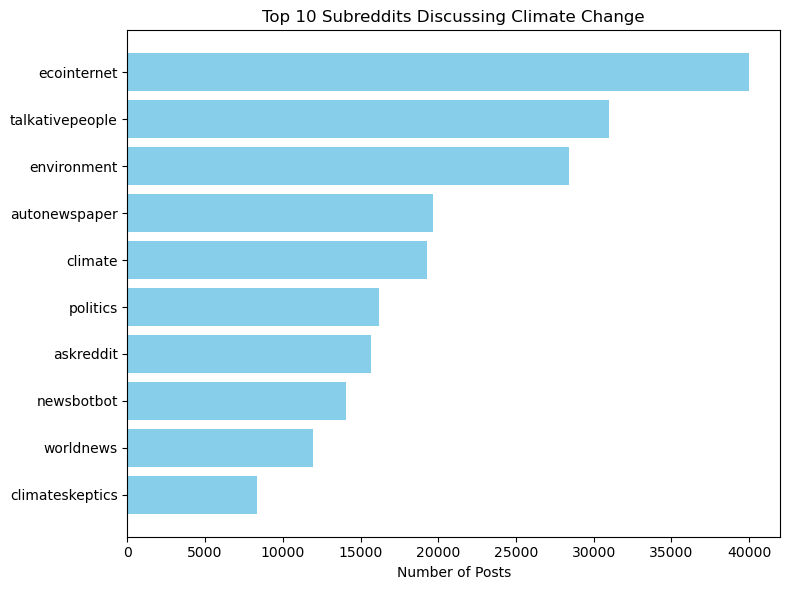

In [ ]:


#  Create a Spark DataFrame with the desired analysis
top_subreddits = df.groupBy("subreddit_name") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10)

# Convert Spark DataFrame to Pandas
top_subs_df = top_subreddits.toPandas()

# Sort for better chart appearance
top_subs_df = top_subs_df.sort_values(by="count", ascending=True)

# Plot chart with Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top_subs_df["subreddit_name"], top_subs_df["count"], color="skyblue")
plt.xlabel("Number of Posts")
plt.title("Top 10 Subreddits Discussing Climate Change")
plt.tight_layout()
plt.show()


### Visualization 2: Top 10 Reddit Posts by Score

This chart displays the most upvoted (highest-scoring) Reddit posts about climate change, highlighting those that received significant community attention.


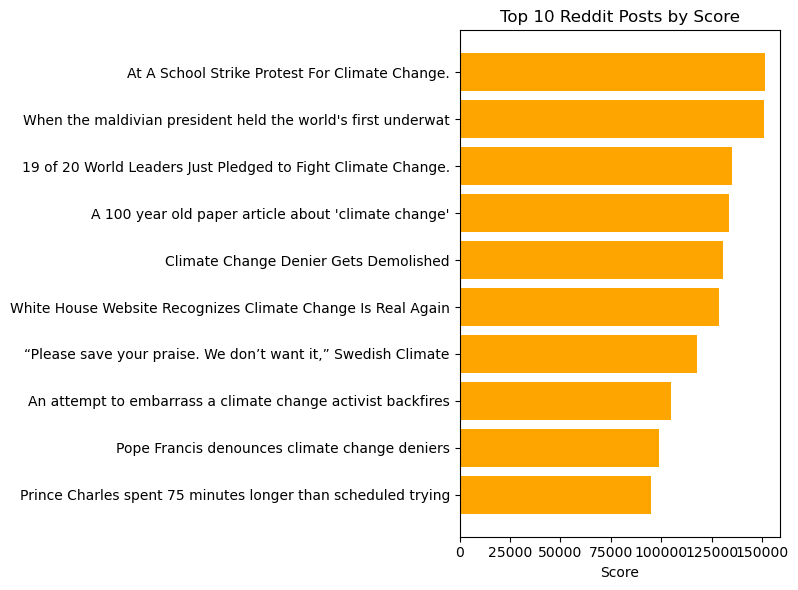

In [ ]:
# 1) Create a Spark DataFrame for the top 10 posts with the highest score
from pyspark.sql.functions import col

top_posts_spark = df.orderBy(col("score").desc()) \
                    .select("title", "score") \
                    .limit(10)

# 2) Convert the Spark DataFrame to Pandas
top_posts_df = top_posts_spark.toPandas()

# 3) Plot the chart with Matplotlib
import matplotlib.pyplot as plt

# Sort from lowest to highest score for better barh display (optional)
top_posts_df = top_posts_df.sort_values(by="score")

plt.figure(figsize=(8, 6))
plt.barh(top_posts_df["title"].str[:60], top_posts_df["score"], color="orange")
plt.xlabel("Score")
plt.title("Top 10 Reddit Posts by Score")


### Visualization 3: Number of Posts Over Time

A simple line chart showing how many posts were made each month or each year about climate change. This helps us observe trends or seasonality in climate-related discussions.


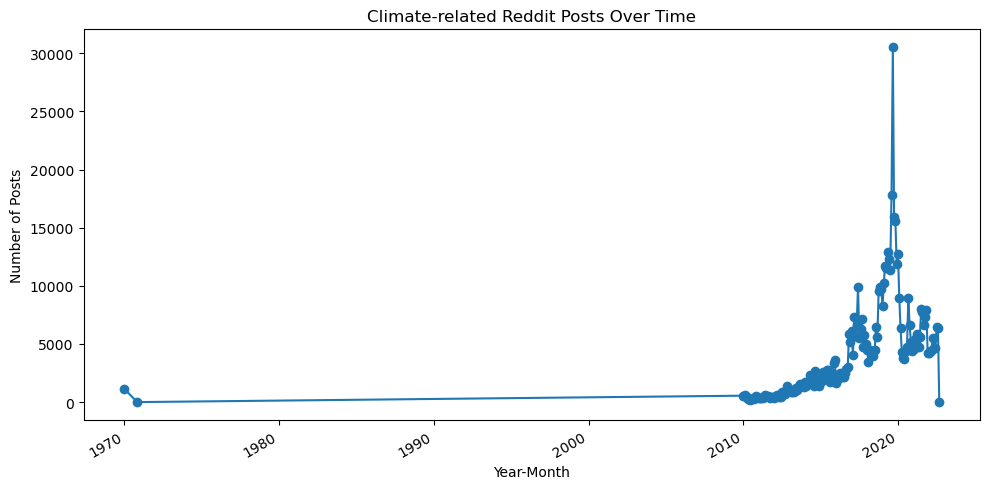

In [ ]:

# 1) Create a Spark DataFrame for time trend (year-month)


from pyspark.sql.functions import col, date_format
df_with_month = df.withColumn("year_month", date_format(col("created_at"), "yyyy-MM"))

posts_time_spark = df_with_month.groupBy("year_month").count().orderBy("year_month")


# 2) Convert to Pandas and change year_month to datetime

posts_time_df = posts_time_spark.toPandas()

# Convert the year_month column (e.g., "2021-07") to Pandas datetime format
import pandas as pd
posts_time_df["year_month"] = pd.to_datetime(posts_time_df["year_month"], format="%Y-%m")


# 3) Plot a line chart using matplotlib


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Now that year_month is in datetime format, the X-axis can show real dates
plt.plot(posts_time_df["year_month"], posts_time_df["count"], marker="o", linestyle="-")

# Auto-format date labels on the X-axis
plt.gcf().autofmt_xdate()

plt.xlabel("Year-Month")
plt.ylabel("Number of Posts")
plt.title("Climate-related Reddit Posts Over Time")
plt.tight_layout()
plt.show()


### Visualization: Score Distribution of Reddit Posts

This chart illustrates how the scores (upvotes) of Reddit posts related to climate change are distributed. We use a histogram to show the frequency of scores and add a Kernel Density Estimate (KDE) curve to visualize the probability distribution.


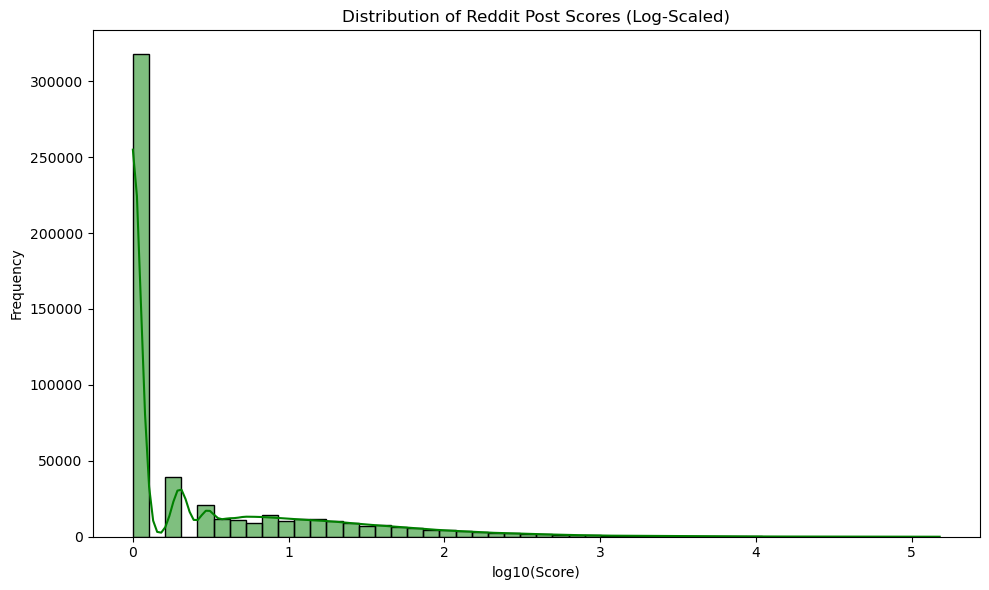

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Create or select a pandas DataFrame that contains the 'score' column
score_pandas_df = df.select("score").toPandas()

# 2) Remove negative or zero values (because log(0) is undefined)
score_pandas_df = score_pandas_df[score_pandas_df["score"] > 0]

# 3) Create a new column 'log_score'
score_pandas_df["log_score"] = np.log10(score_pandas_df["score"])

# 4) Plot a histogram of the log-transformed score column
plt.figure(figsize=(10, 6))
sns.histplot(data=score_pandas_df, x="log_score", kde=True, bins=50, color="green")

plt.title("Distribution of Reddit Post Scores (Log-Scaled)")
plt.xlabel("log10(Score)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Visualization: Treemap of Top 10 Subreddits

A treemap helps visualize how different subreddits compare in terms of their post count. Each rectangle’s area is proportional to the number of posts in that subreddit.


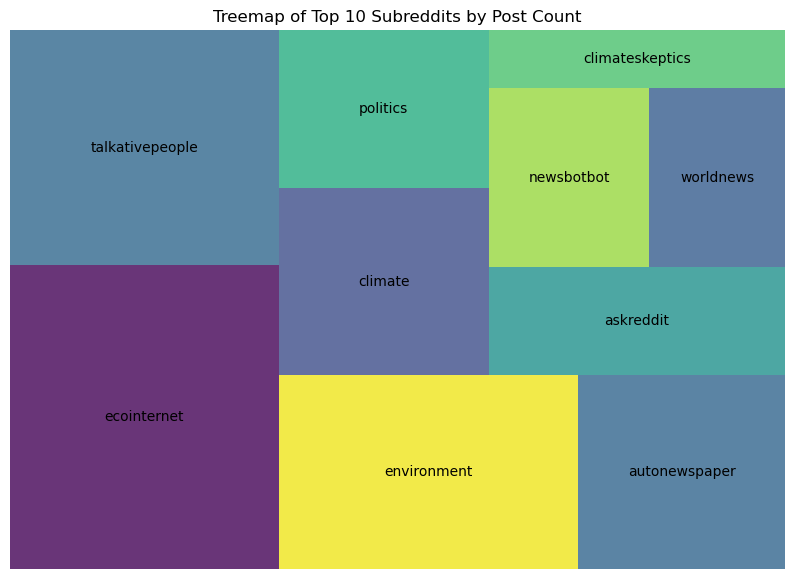

In [ ]:
import squarify
import matplotlib.pyplot as plt

# Let's assume the Spark variable `top_subreddits` contains the columns ["subreddit_name", "count"]
top_subs_df = top_subreddits.toPandas()

# Sort in descending order and keep only the top 10 :
top_subs_df = top_subs_df.sort_values(by="count", ascending=False).head(10)

# Prepare data for squarify 
sizes = top_subs_df["count"].values
labels = top_subs_df["subreddit_name"].values

plt.figure(figsize=(10, 7))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.axis('off')
plt.title("Treemap of Top 10 Subreddits by Post Count")
plt.show()
